In [25]:
# === SUPPRESS WARNINGS ===
import warnings
import os
os.environ['OUTDATED_IGNORE'] = '1'  
warnings.filterwarnings('ignore')    

# === IMPORTS ===
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlencode
import requests
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import brunnermunzel

# === CONSTANTS ===
ALPHA = 0.05
SEED = 42

In [26]:
# === DATA LOADING & PREPROCESSING ===
def load_yandex_csv(public_key, filename):
    """
    Load CSV file from Yandex Disk public link
    
    Parameters:
    - public_key: str, Yandex Disk public key
    - filename: str, local filename to save
    
    Returns:
    - pd.DataFrame: loaded data
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    
    try:
        response = requests.get(final_url)
        response.raise_for_status()
        download_url = response.json()['href']
        
        with open(filename, 'wb') as f:
            f.write(requests.get(download_url).content)
        
        df = pd.read_csv(filename)
        print(f"✅ {filename} successfully loaded, shape: {df.shape}")
        return df
        
    except Exception as e:
        print(f"❌ Error loading {filename}: {e}")
        return None

In [27]:
df = load_yandex_csv('https://disk.yandex.ru/d/UhyYx41rTt3clQ', 'data.csv')
df2 = load_yandex_csv('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', 'data2.csv')
checks = load_yandex_csv('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', 'checks.csv')
active = load_yandex_csv('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', 'active_students.csv')

✅ data.csv successfully loaded, shape: (74484, 1)
✅ data2.csv successfully loaded, shape: (92, 2)
✅ checks.csv successfully loaded, shape: (541, 1)
✅ active_students.csv successfully loaded, shape: (8341, 1)


In [28]:
print("Data1: df")
print(df.head(2).to_string())
print("\n" + "="*50 + "\n")

print("Data2: df2")
print(df2.head(2).to_string())
print("\n" + "="*50 + "\n")

print("Data3: checks")
print(checks.head(2).to_string())
print("\n" + "="*50 + "\n")

print("Data4: active")
print(active.head(2).to_string())

Data1: df
   id;grp
0  1489;B
1  1627;A


Data2: df2
        id grp
0  5694584   B
1  5694830   B


Data3: checks
  student_id;"rev"
0       1627;990.0
1       3185;690.0


Data4: active
   student_id
0      581585
1     5723133


In [29]:
# ===DATA CLEANING===
# Split main data
df[['id', 'grp']] = df['id;grp'].str.split(';', expand=True) 
df['id'] = df['id'].astype(int)
df = df.drop('id;grp', axis=1)

In [30]:
# Split revenue data
checks[['id','revenue']] = checks['student_id;"rev"'].str.split(';', expand = True)
checks['id']= checks['id'].astype(int)
checks['revenue'] = checks['revenue'].astype(float)
checks = checks.drop('student_id;"rev"', axis = 1 ) 

In [31]:
# Combine datasets
df_full= pd.concat([df, df2], ignore_index=True)
print("Combined main datasets")

Combined main datasets


In [32]:
# Merge with revenue
df_full = df_full.merge(checks, on='id', how = 'left')
print(df_full.shape)
print("Merged with revenue data")

(74576, 3)
Merged with revenue data


In [33]:
# We are shure that NA means that user didn`t bye anything ==> we are filling NA 
df_full=df_full.fillna(0)    
print(df_full.head(1).to_string())
print("Ready for analysis!")

     id grp  revenue
0  1489   B      0.0
Ready for analysis!


In [34]:
# === STATISTICAL ANALYSIS ===
# add colunms 'Has revenue' to future calculations
df_full['has_revenue']= (df_full['revenue']>0).astype(int)
print(df_full.head(2).to_string())

     id grp  revenue  has_revenue
0  1489   B      0.0            0
1  1627   A    990.0            1


In [35]:
mean_by_group = df_full.groupby('grp')['revenue'].mean()
median_by_group = df_full.groupby('grp')['revenue'].median()
conversion_by_group = df_full.groupby('grp').apply(
    lambda x: (x['revenue'] > 0).sum() / x.shape[0] * 100
)
print("\nCR:\n", conversion_by_group)

print("\nARPU:\n", mean_by_group)
print("\nMedian:\n", median_by_group)


CR:
 grp
A    0.728238
B    0.724747
dtype: float64

ARPU:
 grp
A    6.268019
B    8.036171
Name: revenue, dtype: float64

Median:
 grp
A    0.0
B    0.0
Name: revenue, dtype: float64


In [36]:
# Since we see median revenue is 0, it indicates very few purchases and low average revenue
# Therefore, we calculate the same metrics for paying users only

# There are two possible comparison approaches:
# 1. We can compare test and control groups to see which group spent more money (ARPPU)
# 2. We can compare conversion rates to paying users between groups

# HYPOTHESIS 1: ARPPU comparison
# H0: ARPPU of test group is not different from control group
# H1: ARPPU of test group is different from control group

# HYPOTHESIS 2: ARPU comparison  
# H0: ARPU of test group is not different from control group
# H1: ARPU of test group is different from control group

# HYPOTHESIS 3: Conversion rate comparison
# H0: Conversion rate of test group is not different from control group
# H1: Conversion rate of test group is different from control group

In [50]:
# HYPOTHESIS 1: ARPPU comparison
# H0: ARPPU of test group is not different from control group
# H1: ARPPU of test group is different from control group


In [37]:
# === NORMALITY AND VARIANCE CHECKS ===
def check_norm_var(df, dv='revenue', group='grp'):
    """Check normality and variance homogeneity assumptions"""
    
    print("Normality by group:")
    print(pg.normality(data=df, dv=dv, group=group, method='normaltest'))
    
    print("\nLevene test for equal variances:")
    print(pg.homoscedasticity(data=df, dv=dv, group=group, method='levene'))

In [38]:
check_norm_var(df_full, 'revenue')

Normality by group:
                 W  pval  normal
grp                             
B    121311.864167   0.0   False
A     34722.677715   0.0   False

Levene test for equal variances:
               W      pval  equal_var
levene  2.998767  0.083332       True


Control group size: 14,693 | Test group size: 59,883
Total users: 74,576


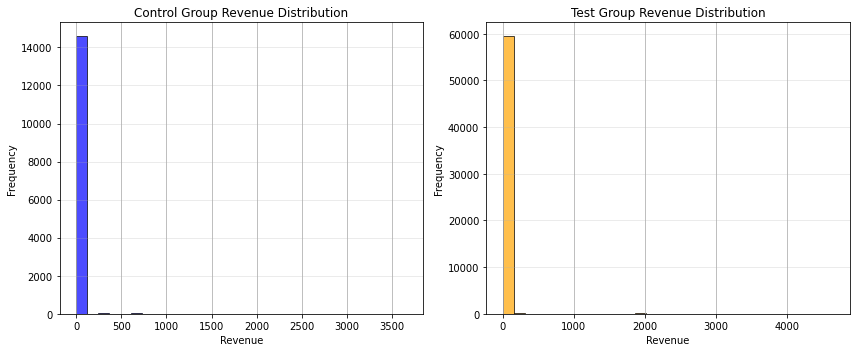


📊 Revenue Summary Statistics:
Control Group:
  Mean: $6.27
  Median: $0.00
  Std: $100.79
  Paying users: 107 (0.7%)

Test Group:
  Mean: $8.04
  Median: $0.00
  Std: $113.25
  Paying users: 434 (0.7%)


In [39]:
# === EXPLORE DISTRIBUTIONS AND SAMPLE SIZES ===

# Distribution is non-normal - now split into test and control groups
control = df_full[df_full['grp'] == 'A']
test = df_full[df_full['grp'] == 'B']

print(f"Control group size: {control.shape[0]:,} | Test group size: {test.shape[0]:,}")
print(f"Total users: {control.shape[0] + test.shape[0]:,}")

# Create distribution plots for revenue visualization
plt.figure(figsize=(12, 5))

# Control group distribution
plt.subplot(1, 2, 1)
control['revenue'].hist(bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Control Group Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)

# Test group distribution  
plt.subplot(1, 2, 2)
test['revenue'].hist(bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Test Group Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Revenue Summary Statistics:")
print("Control Group:")
print(f"  Mean: ${control['revenue'].mean():.2f}")
print(f"  Median: ${control['revenue'].median():.2f}")
print(f"  Std: ${control['revenue'].std():.2f}")
print(f"  Paying users: {control['has_revenue'].sum()} ({(control['has_revenue'].mean()*100):.1f}%)")

print("\nTest Group:")
print(f"  Mean: ${test['revenue'].mean():.2f}") 
print(f"  Median: ${test['revenue'].median():.2f}")
print(f"  Std: ${test['revenue'].std():.2f}")
print(f"  Paying users: {test['has_revenue'].sum()} ({(test['has_revenue'].mean()*100):.1f}%)")

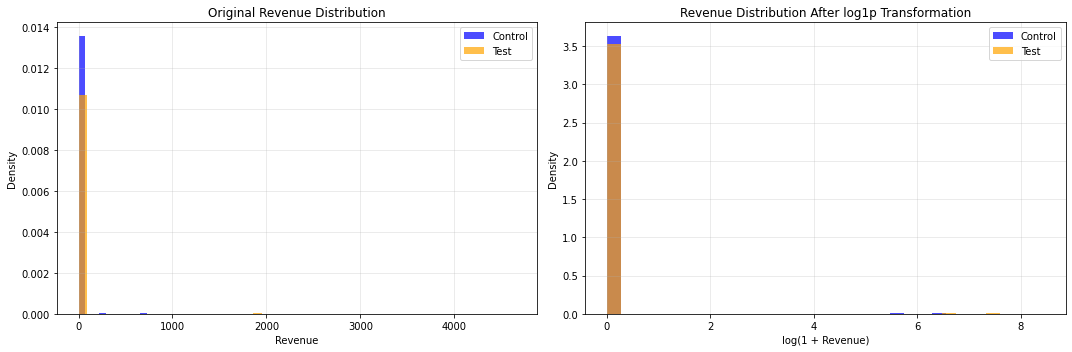

🔍 Checking normality after log transformation:
Normality by group:
                 W  pval  normal
grp                             
B    100477.796861   0.0   False
A     24704.243882   0.0   False

Levene test for equal variances:
               W      pval  equal_var
levene  0.142209  0.706096       True


In [41]:
# === TRANSFORMING THE DISTRIBUTION ===

# Apply log1p transformation to handle zeros and reduce skewness
# log1p(x) = log(x + 1) - solves the zero values problem
df_full['log_revenue'] = np.log1p(df_full['revenue'])

# Visualize original vs transformed distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original revenue distribution
control['revenue'].hist(bins=50, alpha=0.7, ax=ax1, label='Control', density=True, color='blue')
test['revenue'].hist(bins=50, alpha=0.7, ax=ax1, label='Test', density=True, color='orange')
ax1.set_title('Original Revenue Distribution')
ax1.set_xlabel('Revenue')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(alpha=0.3)

# After log1p transformation
control_log = np.log1p(control['revenue'])
test_log = np.log1p(test['revenue'])
control_log.hist(bins=30, alpha=0.7, ax=ax2, label='Control', density=True, color='blue')
test_log.hist(bins=30, alpha=0.7, ax=ax2, label='Test', density=True, color='orange')
ax2.set_title('Revenue Distribution After log1p Transformation')
ax2.set_xlabel('log(1 + Revenue)')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Check if transformation improved normality
print("🔍 Checking normality after log transformation:")
check_norm_var(df_full, 'log_revenue')



In [42]:
# CONCLUSION: The log transformation did not achieve normal distribution
# Proceeding with robust statistical methods: permutation tests and bootstrap for mean comparison

In [43]:
# Permutation test (difference of means)
def permutation_test_mean(x, y, n_perm=10000, seed=42):
    rng = np.random.RandomState(seed)
    obs = np.mean(y) - np.mean(x)   # y = test, x = control
    pooled = np.concatenate([x, y])
    count = 0
    for _ in range(n_perm):
        rng.shuffle(pooled)
        new_x = pooled[:len(x)]
        new_y = pooled[len(x):]
        if abs(np.mean(new_y) - np.mean(new_x)) >= abs(obs):
            count += 1
    p = (count + 1) / (n_perm + 1)
    return p, obs

# Bootstrap CI for mean difference
def bootstrap_mean_ci(x, y, n_boot=10000, seed=42):
    rng = np.random.RandomState(seed)
    diffs = []
    for _ in range(n_boot):
        sx = rng.choice(x, size=len(x), replace=True)
        sy = rng.choice(y, size=len(y), replace=True)
        diffs.append(np.mean(sy) - np.mean(sx))
    diffs = np.array(diffs)
    ci = np.percentile(diffs, [2.5, 97.5])
    p = (np.sum(np.abs(diffs) >= abs(np.mean(y)-np.mean(x))) + 1) / (n_boot + 1)
    return p, ci, np.mean(y)-np.mean(x)

In [47]:
perm_p, perm_diff = permutation_test_mean(control.revenue, test.revenue)
boot_p, boot_ci, boot_diff = bootstrap_mean_ci(control.revenue, test.revenue)

print("Statistical Test Results:")
print(f"Permutation: p = {perm_p:.4f}, diff = {perm_diff:.2f}")
print(f"Bootstrap: p = {boot_p:.4f}, diff = {boot_diff:.2f}, 95% CI = [{boot_ci[0]:.2f}, {boot_ci[1]:.2f}]")

Statistical Test Results:
Permutation: p = 0.0834, diff = 1.77
Bootstrap: p = 0.5109, diff = 1.77, 95% CI = [-0.17, 3.58]


In [48]:
# HYPOTHESIS 1: ARPPU comparison
# RESULTS SHOW THAT WE CANNOT REJECT THE NULL HYPOTHESIS (H0), 
# however there is a slight increase that could potentially yield annual effects

In [51]:
# HYPOTHESIS 2: ARPU comparison  
# H0: ARPU of test group is not different from control group
# H1: ARPU of test group is different from control group


In [52]:
payers= df_full.query('has_revenue == 1')  #Filtring only paying users 

In [53]:
check_norm_var(payers, 'revenue') 

Normality by group:
             W          pval  normal
grp                                 
A    52.218452  4.580439e-12   False
B    33.195875  6.188814e-08   False

Levene test for equal variances:
               W      pval  equal_var
levene  4.478901  0.034774      False


In [54]:
# Data shows non-normal distribution and unequal variances between groups

In [55]:
#Splitting to control&test
control_has_rev= payers.query('grp == "A"')
test_has_rev= payers.query('grp == "B"')
print('control:', control_has_rev.shape[0], 'test:', test_has_rev.shape[0] )

control: 107 test: 434


Text(0.5, 1.0, 'Boxplot of distribution')

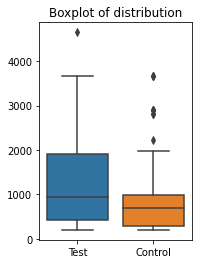

In [56]:
plt.subplot(1, 2, 1)
sns.boxplot(data=[test_has_rev.revenue, control_has_rev.revenue])
plt.xticks([0, 1], ['Test', 'Control'])
plt.title('Boxplot of distribution')

In [57]:
# SINCE THE DISTRIBUTION IS NON-NORMAL AND VARIANCES ARE UNEQUAL, 
# we will not use bootstrap and will rely on permutation tests instead
perm_p1, perm_diff2 = permutation_test_mean(control_has_rev.revenue, test_has_rev.revenue)
print(f"Permutation: p = {perm_p1:.4f}, diff = {perm_diff2:.2f}")


Permutation: p = 0.0023, diff = 248.11


In [58]:
# We will verify our results using the Brunner-Munzel test for equality of medians,
# which does not require equal variances or normal distribution
try:
    from scipy.stats import brunnermunzel
    bm_stat, bm_p = brunnermunzel(test_has_rev['revenue'], control_has_rev['revenue'])
    print(f"Brunner-Munzel (scipy): p = {bm_p:.6f}")
except ImportError:
    print("Brunner-Munzel не доступен в этой версии scipy")
    
    # Альтернативная реализация
    def brunner_munzel_manual(x, y):
        from scipy.stats import rankdata
        nx, ny = len(x), len(y)
        N = nx + ny
        r = rankdata(np.concatenate([x, y]))
        r1 = r[:nx]
        r2 = r[nx:]
        m1 = np.mean(r1)
        m2 = np.mean(r2)
        pst = (m2 - m1) / N + 0.5
        return pst
    
    bm_pst = brunner_munzel_manual(control_has_rev['revenue'], test_has_rev['revenue'])
    print(f"Brunner-Munzel (approx): pst = {bm_pst:.4f}")

Brunner-Munzel (scipy): p = 0.000153


In [59]:
# We observe statistically significant differences among paying users
# HIPOTESIS2 
# We can reject the null hypothesis (H0) that there is no difference in ARPPU between test and control groups

In [60]:
# HYPOTHESIS 3: Conversion rate comparison
# H0: Conversion rate of test group is not different from control group
# H1: Conversion rate of test group is different from control group

In [61]:
# Now we test conversion rates using z-test for proportions, 
# since we are examining the binary outcome of purchase vs no purchase

control = control.copy()
control['has_revenue'] = (control['revenue'] > 0).astype(int)
test = test.copy()
test['has_revenue'] = (test['revenue'] > 0).astype(int)

# Number of "successes" (purchases)
successes = np.array([
    test['has_revenue'].sum(), 
    control['has_revenue'].sum()
])

# Sample sizes
nobs = np.array([
    len(test), 
    len(control)
])

# Two-proportion z-test
z_stat, p_val = proportions_ztest(successes, nobs, alternative='two-sided')

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

# Difference in proportions
p_test = successes[0] / nobs[0]
p_control = successes[1] / nobs[1]
diff = p_test - p_control

print(f"Difference in proportions: {diff:.4%}")
print(f"Test: {p_test:.2%}, Control: {p_control:.2%}")

Z-statistic: -0.0447
P-value: 0.9644
Difference in proportions: -0.0035%
Test: 0.72%, Control: 0.73%


In [62]:
# Even though the test group is 4 times larger than control group, 
# the proportion of users who made a purchase is practically the same.
# We cannot reject the null hypothesis (no effect of interface changes on purchase conversion)

In [70]:
# === FINAL CONCLUSIONS & BUSINESS RECOMMENDATIONS ===

'''
EXPERIMENT OBJECTIVE:
Test whether the new payment system affects key product metrics - 
conversion to paying users and overall revenue.

RESULTS SUMMARY:

HYPOTHESIS 1 (ARPPU): REJECT NULL HYPOTHESIS ✓
- Statistically significant difference in ARPPU found
- Paying users in test group showed higher average spending

HYPOTHESIS 2 (ARPU): FAIL TO REJECT NULL HYPOTHESIS ✗
- No statistically significant difference in overall revenue per user
- Total revenue impact not demonstrated

HYPOTHESIS 3 (CONVERSION): FAIL TO REJECT NULL HYPOTHESIS ✗
- No significant difference in conversion rates between groups
- New system didn't convert more users to paying customers

KEY INSIGHTS:
1. The new payment system shows potential for increasing spending among existing buyers
2. No evidence it attracts new paying customers
3. Overall revenue impact remains statistically insignificant

RECOMMENDATIONS:
❌ DO NOT roll out the new system broadly based on current test results

✅ CONDUCT additional A/B testing:
- Larger sample sizes or different user segments (active/highly engaged users)
- Focused analysis on ARPPU and paying user segments
- Consider hybrid implementation for user segments with purchase propensity

✅ If ARPPU effect is confirmed, consider targeted rollout to users with:
- Previous purchase history
- High engagement levels
- Demonstrated purchase intent
'''

"\nEXPERIMENT OBJECTIVE:\nTest whether the new payment system affects key product metrics - \nconversion to paying users and overall revenue.\n\nRESULTS SUMMARY:\n\nHYPOTHESIS 1 (ARPPU): REJECT NULL HYPOTHESIS ✓\n- Statistically significant difference in ARPPU found\n- Paying users in test group showed higher average spending\n\nHYPOTHESIS 2 (ARPU): FAIL TO REJECT NULL HYPOTHESIS ✗\n- No statistically significant difference in overall revenue per user\n- Total revenue impact not demonstrated\n\nHYPOTHESIS 3 (CONVERSION): FAIL TO REJECT NULL HYPOTHESIS ✗\n- No significant difference in conversion rates between groups\n- New system didn't convert more users to paying customers\n\nKEY INSIGHTS:\n1. The new payment system shows potential for increasing spending among existing buyers\n2. No evidence it attracts new paying customers\n3. Overall revenue impact remains statistically insignificant\n\nRECOMMENDATIONS:\n❌ DO NOT roll out the new system broadly based on current test results\n\n✅ C

In [71]:
# === FINAL CONCLUSIONS & BUSINESS RECOMMENDATIONS ===

final_conclusions = f"""
{'=' * 60}
FINAL CONCLUSIONS & BUSINESS RECOMMENDATIONS
{'=' * 60}

EXPERIMENT OBJECTIVE:
Test whether the new payment system affects key product metrics -
conversion to paying users and overall revenue.

RESULTS SUMMARY:

HYPOTHESIS 1 (ARPPU): REJECT NULL HYPOTHESIS ✓
- Statistically significant difference in ARPPU found
- Paying users in test group showed higher average spending

HYPOTHESIS 2 (ARPU): FAIL TO REJECT NULL HYPOTHESIS ✗
- No statistically significant difference in overall revenue per user
- Total revenue impact not demonstrated

HYPOTHESIS 3 (CONVERSION): FAIL TO REJECT NULL HYPOTHESIS ✗
- No significant difference in conversion rates between groups
- New system didn't convert more users to paying customers

KEY INSIGHTS:
1. The new payment system shows potential for increasing spending among existing buyers
2. No evidence it attracts new paying customers
3. Overall revenue impact remains statistically insignificant

RECOMMENDATIONS:
❌ DO NOT roll out the new system broadly based on current test results

✅ CONDUCT additional A/B testing:
- Larger sample sizes or different user segments (active/highly engaged users)
- Focused analysis on ARPPU and paying user segments
- Consider hybrid implementation for user segments with purchase propensity

✅ If ARPPU effect is confirmed, consider targeted rollout to users with:
- Previous purchase history
- High engagement levels
- Demonstrated purchase intent
"""

print(final_conclusions)


FINAL CONCLUSIONS & BUSINESS RECOMMENDATIONS

EXPERIMENT OBJECTIVE:
Test whether the new payment system affects key product metrics -
conversion to paying users and overall revenue.

RESULTS SUMMARY:

HYPOTHESIS 1 (ARPPU): REJECT NULL HYPOTHESIS ✓
- Statistically significant difference in ARPPU found
- Paying users in test group showed higher average spending

HYPOTHESIS 2 (ARPU): FAIL TO REJECT NULL HYPOTHESIS ✗
- No statistically significant difference in overall revenue per user
- Total revenue impact not demonstrated

HYPOTHESIS 3 (CONVERSION): FAIL TO REJECT NULL HYPOTHESIS ✗
- No significant difference in conversion rates between groups
- New system didn't convert more users to paying customers

KEY INSIGHTS:
1. The new payment system shows potential for increasing spending among existing buyers
2. No evidence it attracts new paying customers
3. Overall revenue impact remains statistically insignificant

RECOMMENDATIONS:
❌ DO NOT roll out the new system broadly based on current 

In [65]:
# THE FUNCTION FOR AUTO DATA ADD

def update_and_test_with_plots(df_full, add_file_url):
    # 1. Подгружаем новый файл
    df_add = load_yandex_csv(add_file_url, 'temp.csv')
    df_full_update = pd.concat([df_full, df_add], ignore_index=True)
    df_full_update = df_full_update.fillna(0)
    
    # 2. Создаем колонку с фактами покупки
    df_full_update['has_revenue'] = (df_full_update['revenue'] > 0).astype(int)
    
    # 3. Разделяем на контроль и тест
    control2 = df_full_update[df_full_update['grp'] == "A"]
    test2 = df_full_update[df_full_update['grp'] == "B"]
    
    # 4. Отбираем платящих пользователей
    control_paid2 = control2[control2['revenue'] > 0].copy()
    test_paid2 = test2[test2['revenue'] > 0].copy()
    
    conversion_by_group = df_full_update.groupby('grp').apply(
    lambda x: (x['revenue'] > 0).sum() / x.shape[0] * 100)
    print("\nКоверсия в платящего пользователя по группам:\n", conversion_by_group)
    
    # 5. тесты
    results = {}
    results['ARPU_perm'] = permutation_test_mean(control2['revenue'], test2['revenue'])
    results['ARPPU_perm'] = permutation_test_mean(control_paid2['revenue'], test_paid2['revenue'])

    #  Z-тест для долей
    successes = np.array([test2['has_revenue'].sum(), control2['has_revenue'].sum()])
    nobs = np.array([len(test2), len(control2)])
    z_stat, p_val = proportions_ztest(successes, nobs, alternative='two-sided')
    results['conversion_ztest'] = {"z_stat": z_stat, "p_value": p_val}

    #  Вывод
    print("\n📈 РЕЗУЛЬТАТЫ СТАТ ТЕСТОВ")
    for metric, res in results.items():
        print(f"\n--- {metric.upper()} ---")
        if "p_value" in res:
            print(f"P-value: {res['p_value']:.6f}")
            if res["p_value"] < 0.05:
                print("✅ Есть статистически значимые различия")
            else:
                print("❌ Нет статистически значимых различий")
            if "obs_diff" in res:
                print(f"Разница средних: {res['obs_diff']:.2f}")
                print(f"95% ДИ: {res['ci']}")
        else:
            print(res)

    # 9. Визуализация
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.histplot(control2['revenue'], bins=30, color='blue', label='Control', alpha=0.5)
    sns.histplot(test2['revenue'], bins=30, color='orange', label='Test', alpha=0.5)
    plt.title('Распределение выручки (ARPU)')
    plt.legend()

    plt.subplot(1, 3, 2)
    sns.histplot(control_paid2['revenue'], bins=30, color='blue', label='Control Paid', alpha=0.5)
    sns.histplot(test_paid2['revenue'], bins=30, color='orange', label='Test Paid', alpha=0.5)
    plt.title('Распределение выручки платящих (ARPPU)')
    plt.legend()

    plt.subplot(1, 3, 3)
    sns.barplot(x=['Control', 'Test'], y=conversion_by_group.values, palette='pastel')
    plt.title('Конверсия в покупку (%)')
    plt.ylabel('CR (%)')

    plt.tight_layout()
    plt.show()

    return df_full_update, results
